In [72]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
from PIL import Image
import os

from pylab import rcParams
rcParams['figure.figsize'] = 20, 20

In [73]:
def fix_image(image):
    #hist_equalization

    # clip all negative values to 0
    image = image.clip(min=0)

    # scale within the interval [0,255]
    image *= 255 / np.max(image)

    # calculate image histogram, with 256 bins returning probability density of each bin
    image_histogram, bins = np.histogram(image.flatten(), 256, normed=True)
    
    # compute the image's cumulative distribution function (CDF)
    cdf = image_histogram.cumsum()
    cdf = 255 * cdf / cdf[-1]

    # use linear interpolation of the CDF to adjust the image
    return np.interp(image.flatten(), bins[:-1], cdf).reshape(image.shape)

In [74]:
QY=np.array([[16,11,10,16,24,40,51,61],
                         [12,12,14,19,26,48,60,55],
                         [14,13,16,24,40,57,69,56],
                         [14,17,22,29,51,87,80,62],
                         [18,22,37,56,68,109,103,77],
                         [24,35,55,64,81,104,113,92],
                         [49,64,78,87,103,121,120,101],
                         [72,92,95,98,112,100,103,99]])

QC=np.array([[17,18,24,47,99,99,99,99],
                         [18,21,26,66,99,99,99,99],
                         [24,26,56,99,99,99,99,99],
                         [47,66,99,99,99,99,99,99],
                         [99,99,99,99,99,99,99,99],
                         [99,99,99,99,99,99,99,99],
                         [99,99,99,99,99,99,99,99],
                         [99,99,99,99,99,99,99,99]])

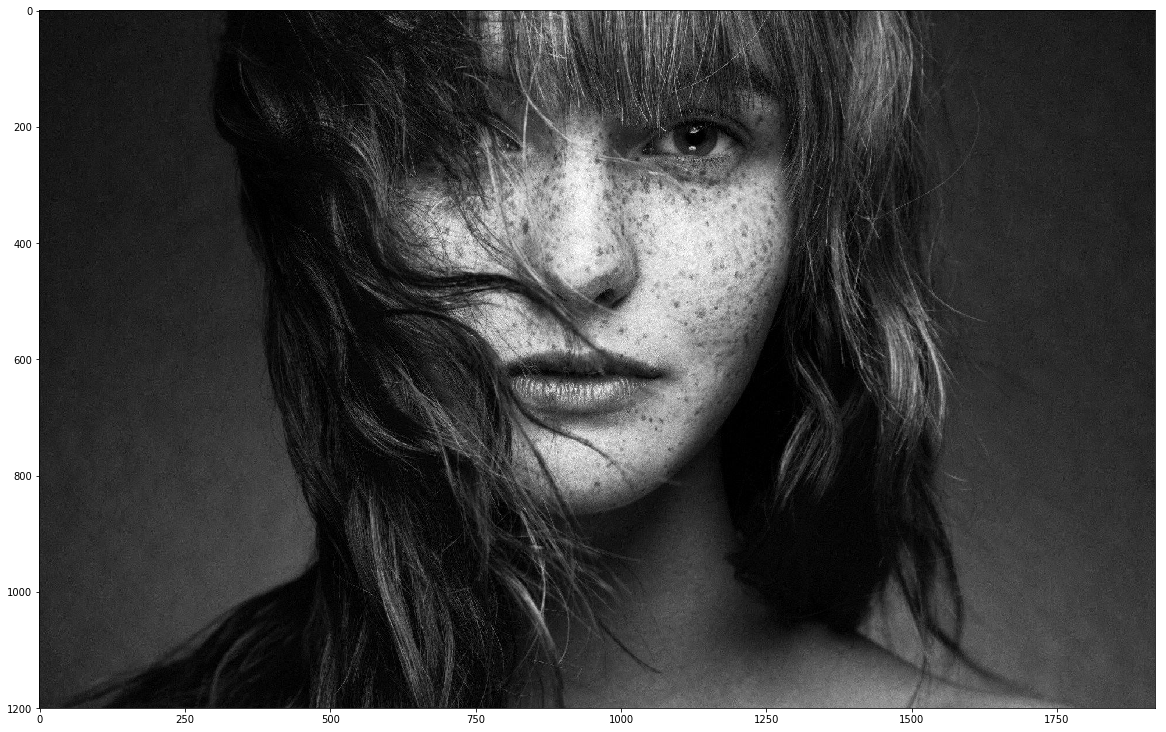

In [75]:
B=8 # blocksize (In Jpeg the
img1 = cv2.imread("girl.jpg",cv2.IMREAD_UNCHANGED)
h,w=np.array(img1.shape[:2])/B * B
img1=img1[:h,:w]

img2=np.zeros(img1.shape,np.uint8)
img2[:,:,0]=img1[:,:,2]
img2[:,:,1]=img1[:,:,1]
img2[:,:,2]=img1[:,:,0]
plt.imshow(img2)

In [76]:
transcol=cv2.cvtColor(img1, cv2.COLOR_BGR2YCR_CB)
SSV=2
SSH=2
crf=cv2.boxFilter(transcol[:,:,1],ddepth=-1,ksize=(2,2))
cbf=cv2.boxFilter(transcol[:,:,2],ddepth=-1,ksize=(2,2))
crsub=crf[::SSV,::SSH]
cbsub=cbf[::SSV,::SSH]
imSub=[transcol[:,:,0],crsub,cbsub]

In [78]:
QF=20.0
if QF < 50 and QF > 1:
        scale = np.floor(5000/QF)
elif QF < 100:
        scale = 200-2*QF
else:
        print "Quality Factor must be in the range [1..99]"
scale=scale/100.0
Q=[QY*scale,QC*scale,QC*scale]

In [90]:
TransAll=[]
TransAllQuant=[]
ch=['Y','Cr','Cb']
r,c = 0, 0
for idx,channel in enumerate(imSub):
        channelrows=channel.shape[0]
        channelcols=channel.shape[1]
        Trans = np.zeros((channelrows,channelcols), np.float32)
        TransQuant = np.zeros((channelrows,channelcols), np.float32)
        blocksV=channelrows/B
        blocksH=channelcols/B
        vis0 = np.zeros((channelrows,channelcols), np.float32)
        vis0[:channelrows, :channelcols] = channel
        vis0=vis0-128
        
        for row in range(blocksV):
                for col in range(blocksH):
                        currentblock = cv2.dct(vis0[row*B:(row+1)*B,col*B:(col+1)*B])
                        Trans[row*B:(row+1)*B,col*B:(col+1)*B]=currentblock
                        TransQuant[row*B:(row+1)*B,col*B:(col+1)*B]=np.round(currentblock/Q[idx])
                        if(np.count_nonzero(TransQuant[row*B:(row+1)*B,col*B:(col+1)*B]) > 4):
                            r = row
                            c = col
                            
        TransAll.append(Trans)
        TransAllQuant.append(TransQuant)

In [92]:
# fig, (ax1, ax2) = plt.subplots(1,2)
# fig.suptitle('JPEG Transformation on 8 X 8 blocks', fontsize=40)
# ax1.set_title('Original DCT Block', fontsize=30)
# im1 = ax1.imshow(gabba,cmap='gray')
# ax2.set_title('Transformed DCT Block', fontsize=30)
# im2 = ax2.imshow(dabba,cmap='gray')
# plt.show()

In [93]:
DecAll=np.zeros((h,w,3), np.uint8)
for idx,channel in enumerate(TransAllQuant):
        channelrows=channel.shape[0]
        channelcols=channel.shape[1]
        blocksV=channelrows/B
        blocksH=channelcols/B
        back0 = np.zeros((channelrows,channelcols), np.uint8)
        for row in range(blocksV):
                for col in range(blocksH):
                        dequantblock=channel[row*B:(row+1)*B,col*B:(col+1)*B]*Q[idx]
                        currentblock = np.round(cv2.idct(dequantblock))+128
                        currentblock[currentblock>255]=255
                        currentblock[currentblock<0]=0
                        back0[row*B:(row+1)*B,col*B:(col+1)*B]=currentblock
        back1=cv2.resize(back0,(w,h))
        DecAll[:,:,idx]=np.round(back1)

Sum of squared error:  17178.652013473


True

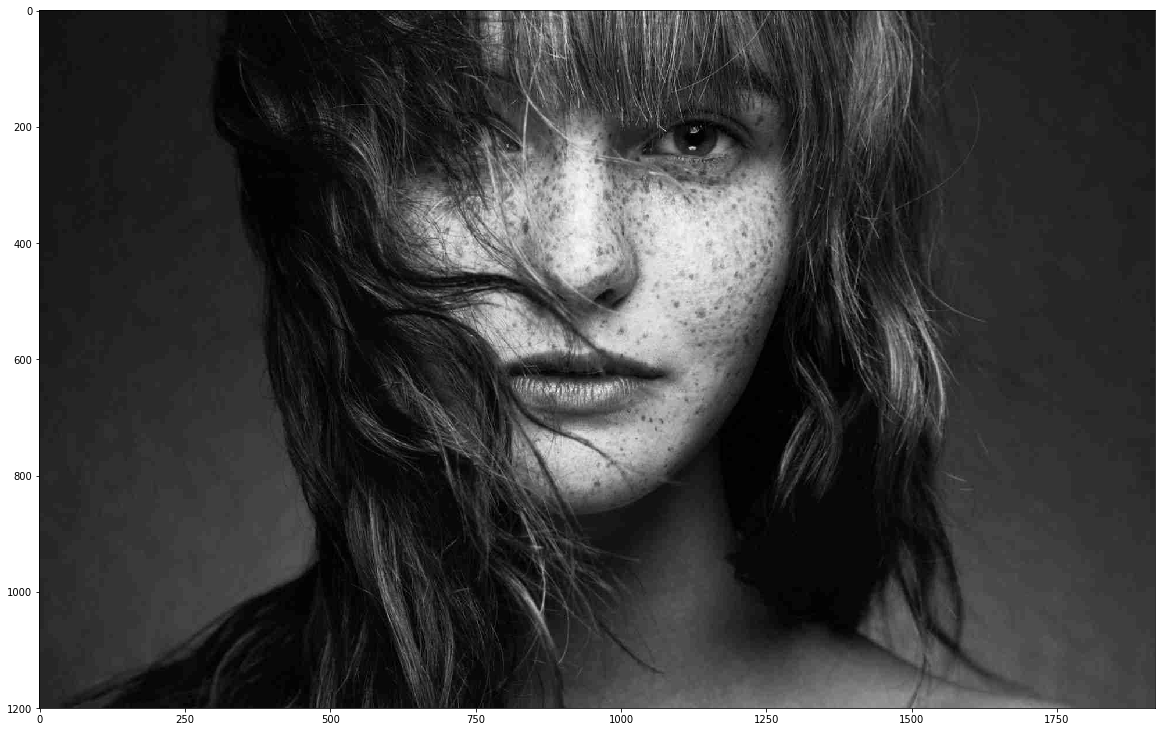

In [81]:
reImg=cv2.cvtColor(DecAll, cv2.COLOR_YCR_CB2BGR)
img3=np.zeros(img1.shape,np.uint8)
img3[:,:,0]=(reImg[:,:,0])
img3[:,:,1]=(reImg[:,:,1])
img3[:,:,2]=(reImg[:,:,2])
plt.imshow(cv2.cvtColor(img3,cv2.COLOR_BGR2RGB))
SSE=np.sqrt(np.sum((img2-img3)**2))
print "Sum of squared error: ",SSE
cv2.imwrite('compressed.jpg',img3)

In [82]:
img_gray = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

In [85]:
img = cv2.imread("girl.jpg",0)
img_trans = cv2.imread("compressed.jpg",0)

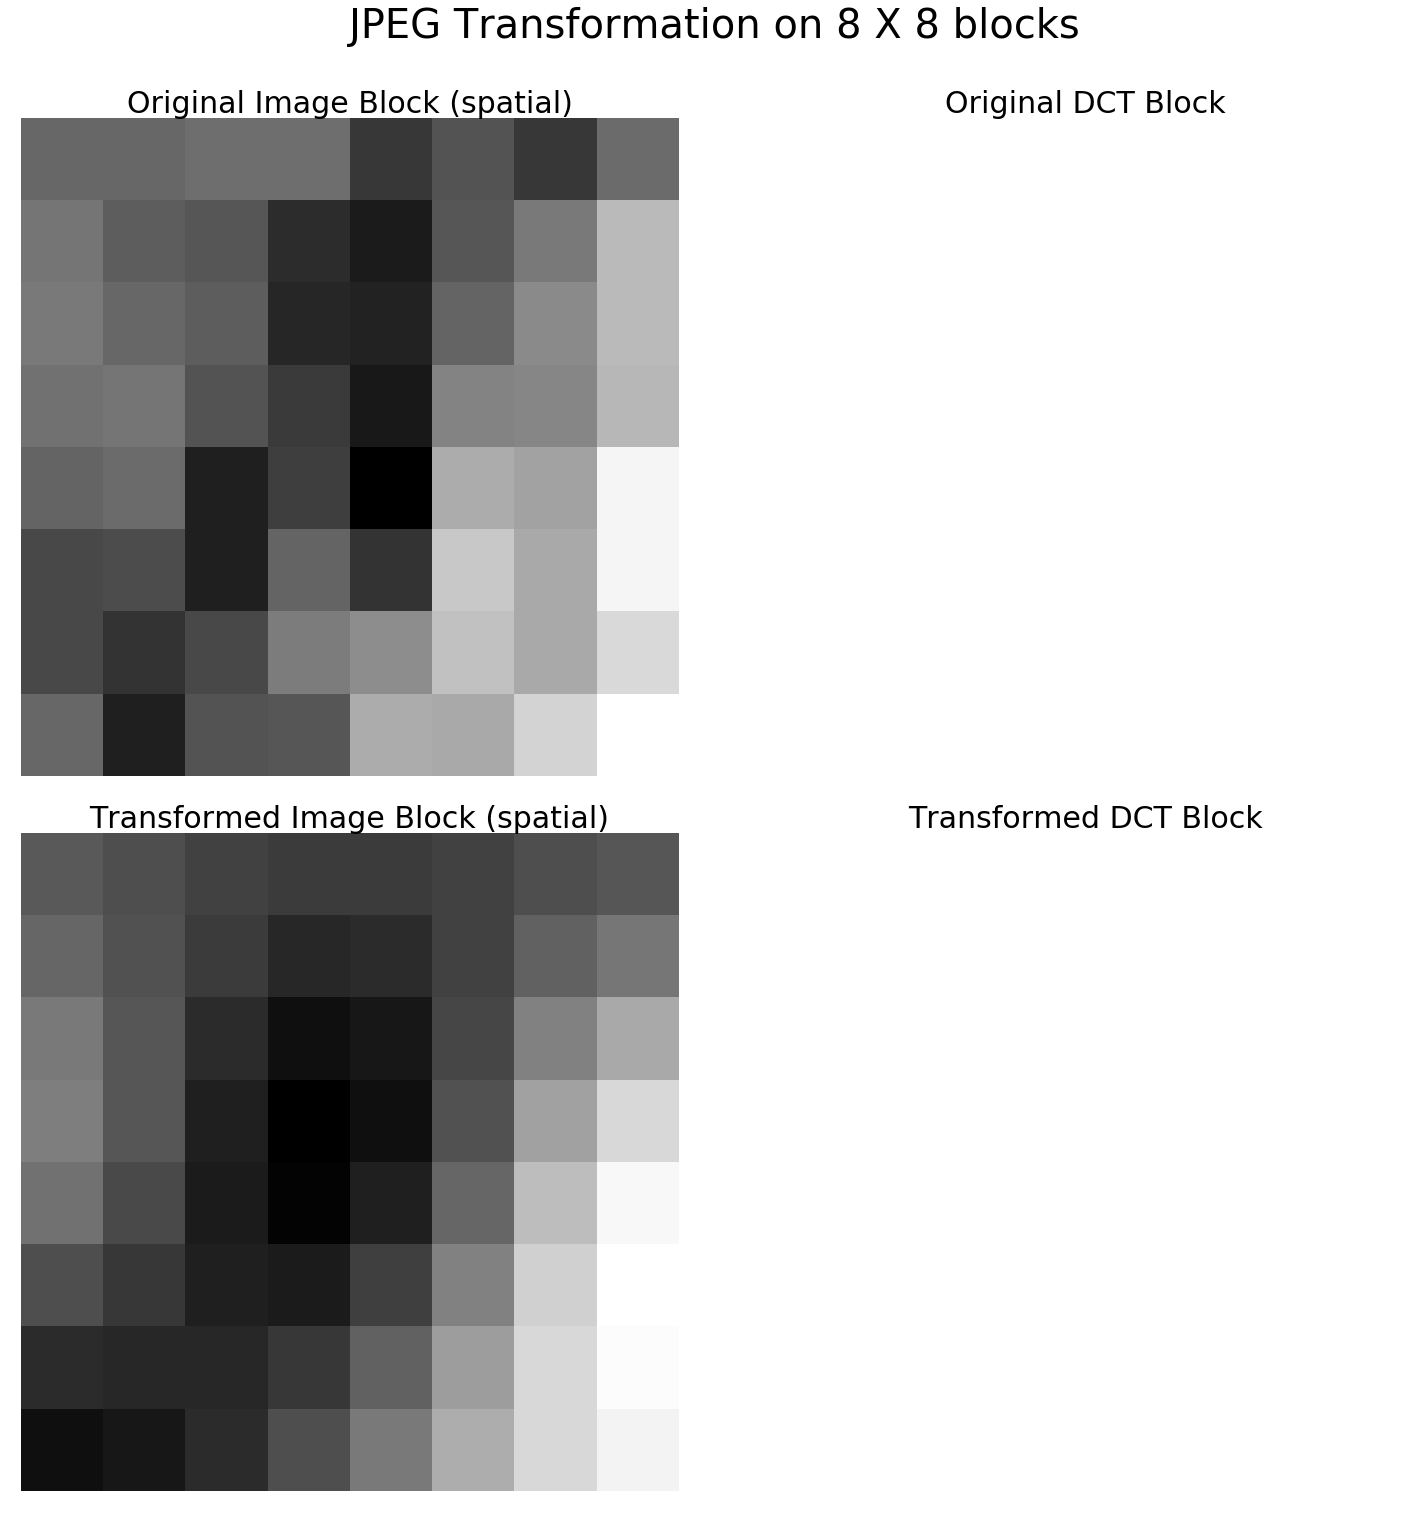

In [94]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2,2)
fig.suptitle('JPEG Transformation on 8 X 8 blocks', fontsize=40, y=1.05)
ax1.set_title('Original Image Block (spatial)', fontsize=30)
im1 = ax1.imshow(img[r*B:(r+1)*B,c*B:(c+1)*B],cmap='gray')
ax2.set_title('Original DCT Block', fontsize=30)
im2 = ax2.imshow(Trans[r*B:(r+1)*B,c*B:(c+1)*B],cmap='gray')
ax3.set_title('Transformed Image Block (spatial)', fontsize=30)
im3 = ax3.imshow(img_gray[r*B:(r+1)*B,c*B:(c+1)*B],cmap='gray')
ax4.set_title('Transformed DCT Block', fontsize=30)
im4 = ax4.imshow(TransQuant[r*B:(r+1)*B,c*B:(c+1)*B])
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
fig.tight_layout()
plt.show()

In [34]:
a = os.path.getsize("MARBLES.BMP")
b = os.path.getsize("compressed.jpg")
print("Size of Uncompressed in bytes : ", a)
print("Size of Compressed in bytes : ", b)
print(a/b)

('Size of Uncompressed in bytes : ', 4264316)
('Size of Compressed in bytes : ', 161397)
26
